In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import os
import pandas as pd
import numpy as np
from ladybug.epw import EPW
from ladybug.sunpath import Sunpath

import oshe as tc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Inputs

In [2]:
idd_file = r"C:\openstudio-2.7.0\EnergyPlus\Energy+.idd"
epw_file = r"C:\Users\tgerrish\Documents\GitHub\oshe\projects\UWG_ARE_AZ_Abu.Dhabi-Bateen.Exec.AP.412160_TMYx_URBAN_02.epw"

# Load weatherfile data

In [3]:
# Load epw
epw = EPW(epw_file)

# Get climate variables
dbt = np.array(epw.dry_bulb_temperature.values)
rh = np.array(epw.relative_humidity.values)
ws = np.array(epw.wind_speed.values)
hir = np.array(epw.horizontal_infrared_radiation_intensity.values)

# Calculate hourly solar altitudes and hir for input
sun_path = Sunpath.from_location(epw.location)
sun_altitude = np.array([sun_path.calculate_sun_from_hoy(i).altitude for i in range(8760)])

# Open-field MRT and UTCI calculation

In [4]:
# Define ground material
gnd_mat = tc.material.material_dict["CONCRETE"]
ground_zone = tc.geometry.Ground(gnd_mat, xy=5, depth=1.5, subsurface_size=5)

# Calculate ground surface temperature
of_srf_temp = tc.energyplus.run_energyplus(epw_file, idd_file, ground=ground_zone, shades=None, run=True)

# Calculate incident solar direct and diffuse radiation
of_dir_rad, of_dif_rad = tc.radiance.run_radiance(epw_file, ground=ground_zone, shades=None, run=True)

# Calculate MRT
of_mrt = tc.mrt.mean_radiant_temperature(surrounding_surfaces_temperature=of_srf_temp[0], horizontal_infrared_radiation_intensity=hir, diffuse_horizontal_solar=of_dif_rad.T[0], direct_normal_solar=of_dir_rad.T[0], sun_altitude=sun_altitude, ground_reflectivity=gnd_mat.reflectivity, sky_exposure=1, radiance=True)[0]

# Calculate UTCI
of_utci = tc.utci.universal_thermal_climate_index(dbt, of_mrt, ws, rh)

Ground surface temperature simulation completed
EnergyPlus results loaded
Writing recipe contents to: C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual
Calculating solar values...
# Number of sun up hours: 4423
Writing sun matrix to C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual\sky\sunmtx.smx
Direct and diffuse solar radiation simulation completed
Radiance results loaded
Mean radiant temperature calculated [0.07 seconds]
Universal thermal climate index calculated [0.09 seconds]


# Post-process Rhino/GH case

In [5]:
# Load case recipe
recipe = "./projects/EXAMPLE/recipe.json"
reload = False

# Create output directory for generated images
output_directory = os.path.dirname(os.path.dirname(recipe))
plot_directory = os.path.join(os.path.dirname(recipe), "plots")
if not os.path.exists(plot_directory):
    os.mkdir(plot_directory)

# Load JSON
d = tc.helpers.load_json(recipe)

# Load surface view factors
surface_view_factors = np.array(d["surface_view_factors"])

# Load sky view factors
sky_view_factors = np.array([[i] for i in d["sky_view_factors"]]) / 100 * 0.5

# Load ground reflectivities
ground_reflectivities = np.array([[i] for i in d["ground_reflectivities"]])

# Load plot tricontour plot 
boundary = np.array(d["boundary"])[:, :-1]

# Load points
points = np.array(d["points"])

if not reload:
    # Read EnergyPlus annual hourly surface temperature results
    surface_temperatures = tc.helpers.load_energyplus_results(d["eplus_results"])

    # Read Radiance simulation annual hourly incident radiation results
    radiation_direct, radiation_diffuse = tc.helpers.load_radiance_results(d["radiation_results"])
    
    # Calculate generic sky temperature
    skytemp = tc.oshe.sky_temperature(hir)

    # Append sky temperature and air temperature onto end of surface temperatures
    all_srf_temps = np.vstack([surface_temperatures, skytemp, dbt])

    # Append sky view factor to end of surface view factors
    all_vfs = np.hstack([surface_view_factors, sky_view_factors])

    # Add view factor to end of each group, bringing total to 1
    makeups = np.where(1 - all_vfs.sum(axis=1) <= 0, 0, 1 - all_vfs.sum(axis=1))
    all_vfs = np.vstack([all_vfs.T, makeups]).T

    # Normalise view factors to 0-1
    all_vfs = all_vfs.T * (1 / all_vfs.sum(axis=1))

    # Calculate overall surrounding surface temperature using view factors and individual surface temperatures
    surrounding_surface_temperatures = np.power(np.matmul(all_vfs.T, np.power(all_srf_temps.T + 273.15, 4).T), 0.25) - 273.15
    print("View-factored surface temperatures calculated")
    

EnergyPlus results loaded
Radiance results loaded
View-factored surface temperatures calculated


# Calculate MRT and write to file

In [6]:
mrt_path = os.path.join(os.path.dirname(recipe), "result.mrt")
if not reload:
    mean_radiant_temperature = tc.mrt.mrt_parallel(
        threads=8, 
        surrounding_surfaces_temperature=surrounding_surface_temperatures, 
        horizontal_infrared_radiation_intensity=hir, 
        diffuse_horizontal_solar=radiation_diffuse, 
        direct_normal_solar=radiation_direct, 
        sun_altitude=sun_altitude, 
        ground_reflectivity=ground_reflectivities, 
        sky_exposure=sky_view_factors, 
        radiance=True
    )

    # Write to file
    df_mrt = pd.DataFrame(mean_radiant_temperature.T)
    df_mrt.round(6).to_csv(mrt_path, index=False)
    print("MRT calculated and written to {}".format(mrt_path))
else:
    mean_radiant_temperature = pd.read_csv(mrt_path).values.T
    print("MRT reloaded from {}".format(mrt_path))

MRT calculated and written to ./projects/EXAMPLE\result.mrt


# Calculate UTCI and write to file

In [7]:
utci_path = os.path.join(os.path.dirname(recipe), "result.utci")
if not reload:
    universal_thermal_climate_index = tc.utci.utci_parallel(
        threads=8, 
        air_temperature=dbt, 
        mean_radiant_temperature=mean_radiant_temperature.T, 
        wind_speed=ws, 
        relative_humidity=rh
    )

    # Write to file
    df_utci = pd.DataFrame(universal_thermal_climate_index.T)
    df_utci.round(6).to_csv(utci_path, index=False)
    print("UTCI calculated and written to {}".format(utci_path))
else:
    universal_thermal_climate_index = pd.read_csv(utci_path).values.T
    print("UTCI reloaded from {}".format(utci_path))

UTCI calculated and written to ./projects/EXAMPLE\result.utci


# Construct results object

GND_STONE not found in radiance geometry - skipping


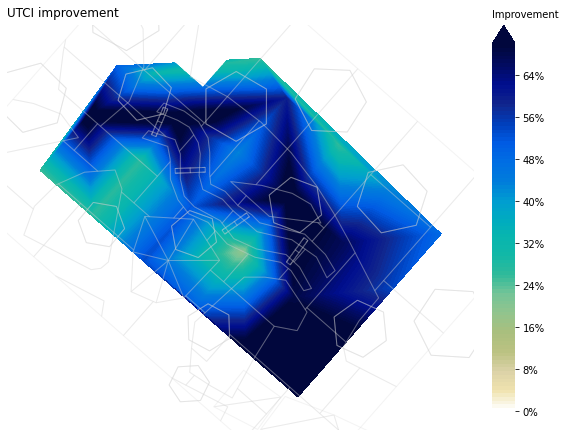

In [213]:
utci = tc.plot2.UTCI(of_utci, universal_thermal_climate_index, points)

# utci.comfort_in_period(utci.mask_shoulder_all)
# utci.reduction_in_period(utci.mask_october_morning, threshold=4)
# utci.reduction_summary()
# tc.plot2.utci_comfort_heatmap(utci.utci[0].values, close=False)
# tc.plot2.utci_day_comparison(utci.utci_openfield, utci.utci[12].values, months=[1, 2, 5, 10], names=["var1", "var2"])
# tc.plot2.utci_reduction_heatmap(utci.utci_difference[0].values, close=False)

rad_files = [
    r"C:\Users\tgerrish\Documents\GitHub\oshe\projects\EXAMPLE\gridbased_annual\scene\glazing\EXAMPLE..glz.rad",
    r"C:\Users\tgerrish\Documents\GitHub\oshe\projects\EXAMPLE\gridbased_annual\scene\opaque\EXAMPLE..opq.rad"
]

# utci.plot_context(rad_files, pts=True, label_pts=True, highlight_pt=[100], tone_color="k", save_path=None, close=False)
utci.plot_contour(_type="improvement", mask=utci.mask_may_morning, rad_files=rad_files, clip=boundary, title=None, tone_color="k", save_path=None, close=False)



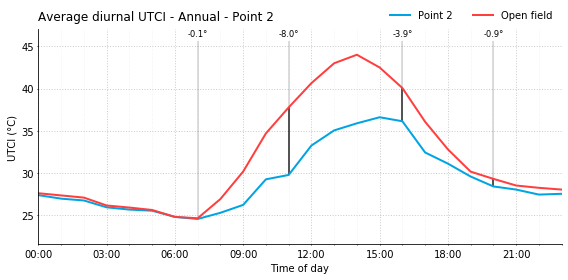

In [44]:
utci.utci_day_comparison(point_idx=2, period="Annual", tone_color="k", save_path=None, close=False)

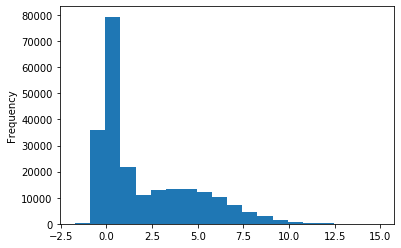

In [41]:
utci.df_utci_reduction.unstack().plot(kind="hist", bins=20)#.quantile(0.5, axis=1)

In [37]:
utci.reduction_summary(threshold=4, quant=0.95)

,Annual,May,October
07:00 - 10:00,25.433790,33.333333,24.193548
16:00 - 19:00,75.506849,80.645161,60.645161


## Generate plots

In [109]:
self = utci
def comfort(self, months=np.arange(1, 13, 1), hours=np.arange(0, 24, 1), lower=9, upper=28):
    
    # Create hour mask for year for selected time periods
    time_mask = self.index.hour.isin(hours) & self.index.month.isin(months)
    count = time_mask.sum()
    
    # Filter the dataset by time
    a = self.utci_points[time_mask]
    
    # Filter the remaining data by comfort
    comfortable_mask = (a >= lower) & (a <= upper)
    b = a[comfortable_mask]
    
    # Count number of potential values
    count_remaining = b.count()

    # Get proportion of comfortbale hours in period
    c = count_remaining / count
    
    return c

comfort(utci, months=[5], hours=[0, 9, 10, 11, 12, 13, 14], lower=9, upper=28)

0     0.087558
1     0.092166
2     0.082949
3     0.073733
4     0.078341
5     0.082949
6     0.082949
7     0.101382
8     0.087558
9     0.082949
10    0.082949
11    0.069124
12    0.092166
13    0.069124
14    0.055300
15    0.046083
16    0.050691
17    0.046083
18    0.055300
19    0.050691
20    0.046083
21    0.036866
22    0.087558
23    0.082949
24    0.069124
25    0.092166
dtype: float64

In [ ]:
# Load Radiance geometry

rad_files = [
    os.path.join(os.path.dirname(d["radiation_results"]), "scene", "opaque", "{}..opq.rad".format(os.path.basename(os.path.dirname(json_location)))),
    os.path.join(os.path.dirname(d["radiation_results"]), "scene", "glazing", "{}..glz.rad".format(os.path.basename(os.path.dirname(json_location))))
]

In [ ]:
# Plot comfort and reduction plan

for t in ["comfort", "reduction", "improvement"][0:]:
    for s_period in ["Annual", "May", "October"][0:]:
        for d_period in ["Morning Shoulder", "Afternoon Shoulder", "Morning & Afternoon Shoulder"][0:]:
            
            sp = os.path.join(plot_directory, "_{0:}_{1:}_{2:}.png".format(t, s_period.lower(), d_period.lower()).replace("&", "").replace(" ", ""))
            
            utci.plot_plan(rad_files, _type=t, day_period=d_period, season_period=s_period, save_path=sp, pts=False, label_pts=None, legend=False, highlight_pt=None, clip=boundary, tone_color="k", close=True)

In [ ]:
# Plot context plan

utci.plot_plan(rad_files, save_path=os.path.join(plot_directory, "context.png"), pts=False, label_pts=None, legend=True, highlight_pt=None, tone_color="k", close=True)
utci.plot_plan(rad_files, save_path=os.path.join(plot_directory, "context_ptlabels.png"), pts=True, label_pts=1, legend=True, highlight_pt=None, tone_color="k", close=True)

In [ ]:
# Review pt locations and choose focal pts for plotting

if "P1" in json_location:
    focus_pts = [1148, 1597, 1672, 1880]  # P1
elif "P2" in json_location:
    focus_pts = [829, 1344, 1222]  # P2
elif "P3" in json_location:
    focus_pts = [1416, 1516, 1524]  # P3
elif "FAMILYPARK1" in json_location:
    focus_pts = [328, 414, 566, 1046]
elif "FAMILYPARK2" in json_location:
    focus_pts = [100, 636, 860, 1038, 1088, 1202]
elif "KHALIDIYA" in json_location:
    focus_pts = [795, 856, 962]
elif "MUNICIPALITY" in json_location:
    focus_pts = [192, 825, 1053]

utci.plot_plan(rad_files, save_path=os.path.join(plot_directory, "focuspoints_location.png"), pts=False, label_pts=None, legend=True, highlight_pt=focus_pts, tone_color="k", close=True)

In [ ]:
# Plot UTCI day and heatmap comparison plots for focus pts

for pt_idx in focus_pts[0:]:
    for period in ["May", "October", "May & October"]:
        sp = os.path.join(plot_directory, "pt{0:04.0f}_profile_{1:}.png".format(pt_idx, period.lower()).replace("&", "").replace(" ", ""))
        utci.utci_day_comparison(point_idx=pt_idx, period=period, tone_color="k", save_path=sp, close=True)

In [ ]:
# Plot comfort heatmaps for each pt

utci.utci_heatmap(save_path=os.path.join(plot_directory, "openfield_comfortheatmap.png".format(pt_idx)), close=True)

for pt_idx in focus_pts[0:]:
    sp = os.path.join(plot_directory, "pt{0:04.0f}_comfortheatmap.png".format(pt_idx))
    utci.utci_heatmap(point_idx=pt_idx, save_path=sp, close=True)

In [ ]:
# Plot reduction heatmaps for each pt

for pt_idx in focus_pts[0:]:
    sp = os.path.join(plot_directory, "pt{0:04.0f}_reductionheatmap.png".format(pt_idx))
    utci.utci_reduction_heatmap(point_idx=pt_idx, save_path=sp, close=True)

In [ ]:
# Tile images for ease of inserting into Word!

from PIL import Image

def get_concat_h2(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_h3(im1, im2, im3):
    dst = Image.new('RGB', (im1.width + im2.width + im3.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    dst.paste(im3, (im1.width + im2.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def get_concat_v3(im1, im2, im3):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height + im3.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    dst.paste(im3, (0, im1.height + im2.height))
    return dst

for t in ["comfort", "reduction", "improvement"][0:]:
    column = []
    for s_period in ["Annual", "May", "October"][0:]:
        row = []
        for d_period in ["Morning Shoulder", "Afternoon Shoulder", "Morning & Afternoon Shoulder"][0:-1]:
            
            sp = os.path.join(plot_directory, "_{0:}_{1:}_{2:}.png".format(t, s_period.lower(), d_period.lower()).replace("&", "").replace(" ", ""))
            row.append(Image.open(sp))
        column.append(row)

    b = []
    for r in column:
        b.append(get_concat_h2(r[0], r[1]))
    
    c = get_concat_v3(b[0], b[1], b[2])
    planpath = os.path.join(plot_directory, "_{0:}__collection.png".format(t).replace("&", "").replace(" ", ""))
    print("Contour plots joined in {}".format(planpath))
    c.save(planpath)

for pt_idx in focus_pts[0:]:
    
    spcomf = Image.open(os.path.join(plot_directory, "pt{0:04.0f}_comfortheatmap.png".format(pt_idx)))
    spred = Image.open(os.path.join(plot_directory, "pt{0:04.0f}_reductionheatmap.png".format(pt_idx)))
    
#     fix image width issue
    # profiles
    st = []
    for period in ["May", "October"]:
        sp = os.path.join(plot_directory, "pt{0:04.0f}_profile_{1:}.png".format(pt_idx, period.lower()).replace("&", "").replace(" ", ""))
        st.append(Image.open(sp))
    a = get_concat_h2(st[0], st[1])
    a.save(os.path.join(plot_directory, "pt{0:04.0f}_profile_collected.png".format(pt_idx).replace("&", "").replace(" ", "")))
    # resize profiles
    basewidth = 4470
    wpercent = (basewidth/float(a.size[0]))
    hsize = int((float(a.size[1])*float(wpercent)))
    a = a.resize((basewidth, hsize), Image.ANTIALIAS)
    b = get_concat_v3(spcomf, spred, a)
    point_path = os.path.join(plot_directory, "pt{0:04.0f}_collected.png".format(pt_idx).replace("&", "").replace(" ", ""))
    print("Point plots joined in {}".format(point_path))
    b.save(point_path)

In [ ]:
# Re-jig the utci for key points, where RH and DBT are adjusted based on evaporative cooling

from PIL import Image

def get_concat_h2(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_h3(im1, im2, im3):
    dst = Image.new('RGB', (im1.width + im2.width + im3.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    dst.paste(im3, (im1.width + im2.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def get_concat_v3(im1, im2, im3):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height + im3.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    dst.paste(im3, (0, im1.height + im2.height))
    return dst

def rejig_utci(dbt, mrt, rh, ws, water_distance=3.5, wind_stream=0.5, water_effective_distance=10):
    from ladybug.psychrometrics import wet_bulb_from_db_rh, rel_humid_from_db_wb
    wb_db_rh = np.vectorize(wet_bulb_from_db_rh)
    rh_db_wb = np.vectorize(rel_humid_from_db_wb)
    # Maximum distance from water body is 6m, and at the water body, DBT would equal WBT, at 10m DBT woudl equal DBT
    # water_effective_distance = 10
    # water_distance = 3.5  # [m]
    # wind_stream = 0.9  # 1 is fully within downwind stream, 0 is outside downwind stream
    
    # Calculate WBT
    wbt = wb_db_rh(dbt, rh)
    
    # Adjust effective DBT based on location
    wbt_factor = max(0, (water_effective_distance - water_distance) * wind_stream / water_effective_distance)
    dbt_factor = 1 - wbt_factor
    dbt_adjusted = dbt * dbt_factor + wbt * wbt_factor

    # Get new RH fom adjusted DBT
    rh_adjusted = rh_db_wb(dbt_adjusted, wbt)

    return tc.utci.universal_thermal_climate_index(dbt_adjusted, mrt, ws, rh_adjusted)

d = {
    192: {
        "water_distance": 1,
        "wind_stream": 0.5,
        "water_effective_distance": 10
    },
    825: {
        "water_distance": 1,
        "wind_stream": 0.95,
        "water_effective_distance": 10
    },
    1053: {
        "water_distance": 6,
        "wind_stream": 0.75,
        "water_effective_distance": 10
    }
}
n = 0
for k, v in d.items():
    if n>=9999999:
        pass
    else:

        # Construct results object
        fake_utci = np.tile(rejig_utci(dbt, mean_radiant_temperature[k], rh, ws, water_distance=v["water_distance"], wind_stream=v["wind_stream"], water_effective_distance=v["water_effective_distance"]), (k+1, 1))
        fake_pts = np.tile(np.array([0, 0, 0]), (k+1, 1))
        print(of_utci.shape, fake_utci.shape, fake_pts.shape)

        utci = tc.plot.UTCI(of_utci[0], fake_utci, fake_pts)
        focus_pts = [k]

        for pt_idx in focus_pts[0:]:
            for period in ["May", "October", "May & October"]:
                sp = os.path.join(plot_directory, "pt{0:04.0f}_profile_{1:}.png".format(pt_idx, period.lower()).replace("&", "").replace(" ", ""))
                utci.utci_day_comparison(point_idx=pt_idx, period=period, tone_color="k", save_path=sp, close=True)

        for pt_idx in focus_pts[0:]:
            sp = os.path.join(plot_directory, "pt{0:04.0f}_comfortheatmap.png".format(pt_idx))
            utci.utci_heatmap(point_idx=pt_idx, save_path=sp, close=True)

        for pt_idx in focus_pts[0:]:
            sp = os.path.join(plot_directory, "pt{0:04.0f}_reductionheatmap.png".format(pt_idx))
            utci.utci_reduction_heatmap(point_idx=pt_idx, save_path=sp, close=True)


        for pt_idx in focus_pts[0:]:

            spcomf = Image.open(os.path.join(plot_directory, "pt{0:04.0f}_comfortheatmap.png".format(pt_idx)))
            spred = Image.open(os.path.join(plot_directory, "pt{0:04.0f}_reductionheatmap.png".format(pt_idx)))

            st = []
            for period in ["May", "October"]:
                sp = os.path.join(plot_directory, "pt{0:04.0f}_profile_{1:}.png".format(pt_idx, period.lower()).replace("&", "").replace(" ", ""))
                st.append(Image.open(sp))
            a = get_concat_h2(st[0], st[1])
            a.save(os.path.join(plot_directory, "pt{0:04.0f}_profile_collected.png".format(pt_idx).replace("&", "").replace(" ", "")))

            # resize profiles
            basewidth = 4470
            wpercent = (basewidth/float(a.size[0]))
            hsize = int((float(a.size[1])*float(wpercent)))
            a = a.resize((basewidth, hsize), Image.ANTIALIAS)
            b = get_concat_v3(spcomf, spred, a)
            point_path = os.path.join(plot_directory, "pt{0:04.0f}_collected.png".format(pt_idx).replace("&", "").replace(" ", ""))

            print("Point plots joined in {}".format(point_path))
            b.save(point_path)
    n+=1

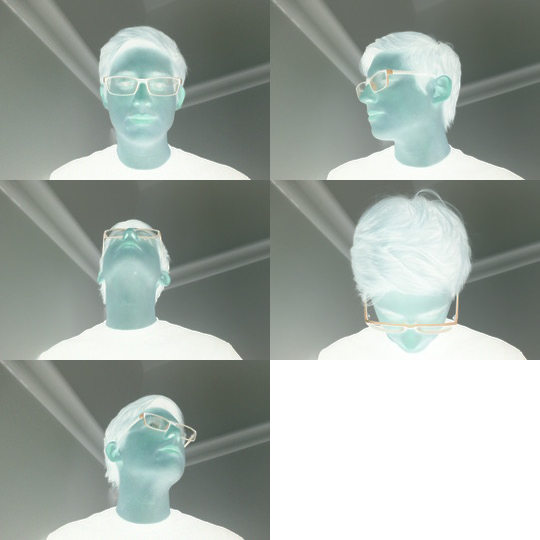

In [28]:
from PIL import Image
import PIL.ImageOps

ims = [
    PIL.ImageOps.invert(Image.open("/Users/tristan/Desktop/File0.jpg")), 
    PIL.ImageOps.invert(Image.open("/Users/tristan/Desktop/File1.jpg")), 
    PIL.ImageOps.invert(Image.open("/Users/tristan/Desktop/File2.jpg")), 
    PIL.ImageOps.invert(Image.open("/Users/tristan/Desktop/File3.jpg")), 
    PIL.ImageOps.invert(Image.open("/Users/tristan/Desktop/File4.jpg")), 
    PIL.ImageOps.invert(Image.open("/Users/tristan/Desktop/File5.jpg")), 
    PIL.ImageOps.invert(Image.open("/Users/tristan/Desktop/File6.jpg")), 
    PIL.ImageOps.invert(Image.open("/Users/tristan/Desktop/File7.jpg")), 
    PIL.ImageOps.invert(Image.open("/Users/tristan/Desktop/File8.jpg"))
]

from oshe.plot2 import append_images

a = append_images([ims[0], ims[1]], direction='horizontal', bg_color=(255,255,255), aligment='center')
b = append_images([ims[2], ims[3]], direction='horizontal', bg_color=(255,255,255), aligment='center')
c = ims[4]

append_images([a, b, c], direction='vertical', bg_color=(255, 255, 255), aligment='left')
